#### 다시 얕은 신경망 120분으로 묶고, 사용 데이터 늘리기

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [12]:
# 1. 데이터 전처리
def create_classification_targets(data, window_size=120, pred_offset=3):
    X = []
    y = []
    for i in range(len(data) - window_size - pred_offset + 1):
        sequence = data.iloc[i:i+window_size]
        scaled_sequence = scale_within_sequence(sequence)
        X.append(scaled_sequence)
        # 3분 뒤의 Close 가격 변화에 따른 클래스 설정
        future_close = data.iloc[i+window_size+pred_offset-1]['Close']
        current_close = data.iloc[i+window_size-1]['Close']
        
        # 가격 변화에 따라 클래스 설정: 상승(2), 보합(1), 하락(0)
        if future_close > current_close:
            y.append(2)  # 상승
        elif future_close < current_close:
            y.append(0)  # 하락
        else:
            y.append(1)  # 보합
    return np.array(X), np.array(y)

# 데이터 불러오기 및 전처리
data = pd.read_csv('./000660.csv', parse_dates=['Unnamed: 0'])
data = data.rename(columns={'Unnamed: 0': 'Time', 
                            '매수량': 'BuyVolume', 
                            '매도량': 'SellVolume', 
                            '종가': 'Close', 
                            '저가': 'Low',
                            '시가': 'Open',
                            '고가': 'High'})
data['Power'] = data['BuyVolume'] - data['SellVolume']
columns = ['Close', 'Power', 'Low', 'Open', 'High', 'MA5', 'MA20', 'MA60', 'MA120', 'Upper_Band', 'Lower_Band']
data = data[columns].dropna()

# 데이터 정규화
# Power 전체 스케일
volume_scaler = RobustScaler()
data['Scaled_Power'] = volume_scaler.fit_transform(data[['Power']])

# 시퀀스내 스케일 종가, 저가
def scale_within_sequence(sequence):
    # 종가 스케일 시퀀스내
    close_scaler = RobustScaler()
    close_scaled = close_scaler.fit_transform(sequence[['Close']].values)
    
    # 나머지 스케일 시퀀스내
    low_scaled = close_scaler.transform(sequence[['Low']].values)
    open_scaled = close_scaler.transform(sequence[['Open']].values)
    high_scaled = close_scaler.transform(sequence[['High']].values)
    ma5_scaled = close_scaler.transform(sequence[['MA5']].values)
    ma20_scaled = close_scaler.transform(sequence[['MA20']].values)
    ma60_scaled = close_scaler.transform(sequence[['MA60']].values)
    ma120_scaled = close_scaler.transform(sequence[['MA120']].values)
    upperBand_scaled = close_scaler.transform(sequence[['Upper_Band']].values)
    lowerBand_scaled = close_scaler.transform(sequence[['Lower_Band']].values)
    
    # 거래량 미리 스케일값 사용
    power_scaled = sequence[['Scaled_Power']].values
    
    return np.hstack([open_scaled, high_scaled, low_scaled, close_scaled, power_scaled, 
                      ma5_scaled, ma20_scaled, ma60_scaled, ma120_scaled, upperBand_scaled, lowerBand_scaled])


X, y = create_classification_targets(data)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)  # (samples, 10, 3)
print(y_train.shape)  # (samples,)

(149279, 120, 11)
(149279,)


In [13]:
X.shape
X.shape[1:]

(120, 11)

In [14]:
# y 클래스 데이터 분포 확인
print(np.bincount(y_train))

[52500 45668 51111]


In [15]:
# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [16]:
# 2. Positional Encoding 구현
def positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    # 짝수 인덱스에 대해 sin 적용
    sines = np.sin(angle_rads[:, 0::2])

    # 홀수 인덱스에 대해 cos 적용
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    return pos_encoding

def add_positional_encoding(inputs, max_len, d_model):
    pos_encoding = positional_encoding(max_len, d_model)
    pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)
    
    pos_encoded_inputs = inputs + pos_encoding[:tf.shape(inputs)[1], :]
    return pos_encoded_inputs

# 3. Transformer 블록 구현
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu", kernel_initializer='he_normal'), layers.Dense(d_model)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output1 = self.att1(inputs, inputs)
        attn_output1 = self.dropout1(attn_output1)
        out1 = self.layernorm1(inputs + attn_output1)
        attn_output2 = self.att2(out1, out1)
        attn_output2 = self.dropout2(attn_output2)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout1(ffn_output)
        return self.layernorm2(out2 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate
        })
        return config

# 4. Transformer 모델 구성
def create_transformer_model(input_shape, num_heads, ff_dim, d_model, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # 임베딩 및 위치 인코딩
    embedding_layer = layers.Dense(d_model, kernel_initializer='he_normal')(inputs)
    pos_encoded_inputs = add_positional_encoding(embedding_layer, max_len=input_shape[0], d_model=d_model)

    # Transformer 블록 적용
    transformer_block = TransformerBlock(d_model, num_heads, ff_dim)
    x = transformer_block(pos_encoded_inputs)
    
    # 출력 레이어
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="gelu", kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
# 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_17.2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8, 
    patience=50, 
    min_lr=0.00001
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [18]:
# 5. 모델 생성 및 학습
input_shape = X.shape[1:]  # 10분 동안의 데이터 
model = create_transformer_model(input_shape, num_heads=4, ff_dim=128, d_model=128, num_classes=3)

# 모델 컴파일
model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 모델 학습
history = model.fit(X_train, 
                    y_train, 
                    epochs=1000, 
                    batch_size=128, 
                    validation_data=(X_test, y_test), 
                    class_weight=class_weights_dict,
                    callbacks=callbacks
                    )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 11)]    0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 120, 128)     1536        ['input_2[0][0]']                
                                                                                                  
 tf.compat.v1.shape_1 (TFOpLamb  (3,)                0           ['dense_5[0][0]']                
 da)                                                                                              
                                                                                                  
 tf.__operators__.getitem_1 (Sl  ()                  0           ['tf.compat.v1.shape_1[0][0

In [19]:
# 자세한 성능 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

1167/1167 [==============================] - 13s 11ms/step
              precision    recall  f1-score   support

           0       0.49      0.33      0.40     13183
           1       0.37      0.50      0.43     11301
           2       0.45      0.47      0.46     12836

    accuracy                           0.43     37320
   macro avg       0.44      0.43      0.43     37320
weighted avg       0.44      0.43      0.43     37320



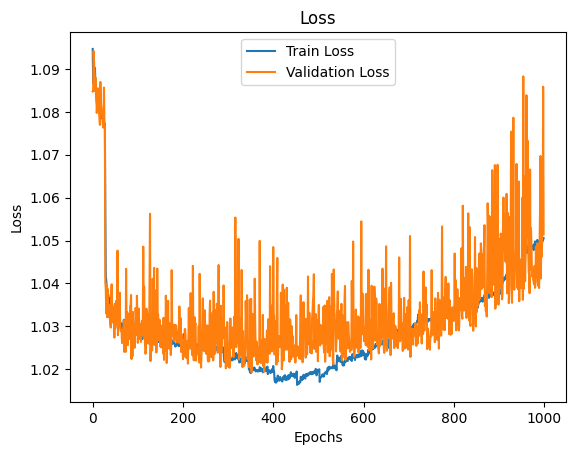

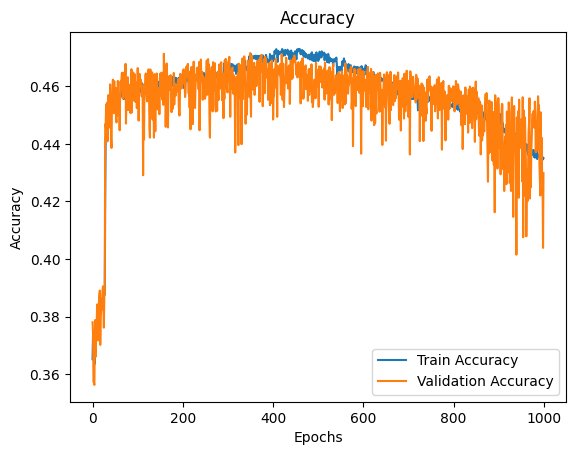

In [20]:
import matplotlib.pyplot as plt

# 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()